In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
#from stage_1_model_v1 import *
import stage_1_util_v1
from parse_lsp_data import *

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
from drawLines import drawLines

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2460834697263736748
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15785944679
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3290457968855830322
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [4]:
from stage_1_modelClass_v1 import *
tfe.enable_eager_execution()

In [69]:
train_list, train_label, val_list, val_label, test_list, test_label = getLSPDataset(0.8, 0.1)
train_X = train_list	# (N, 227, 227, 3)
train_Y = train_label	# (N, 2, 14)
print("train X: ", train_list.shape, "val X: ", val_list.shape, "test X: ", test_list.shape)
print("train Y: ", train_label.shape, "val Y: ", val_label.shape, "test Y: ", test_label.shape)

Resizing and packing images and labels to lists.

Start to process training dataset
Done processing the training dataset
Start to process validation dataset
Done processing the validation dataset
Start to process test dataset
Done processing the test dataset
train X:  (1600, 227, 227, 3) val X:  (200, 227, 227, 3) test X:  (200, 227, 227, 3)
train Y:  (1600, 2, 14) val Y:  (200, 2, 14) test Y:  (200, 2, 14)


In [6]:
train_X = train_list
train_Y = train_label

n_samples = train_Y.shape[0] # N
n_joints = train_Y.shape[2]

# Parameters
learning_rate = 0.00005
batch_size = 128
display_step = 1
epochs = 250
if n_samples % batch_size == 0:
    n_batch = int(n_samples / batch_size)
else:
    n_batch = int(n_samples / batch_size) + 1
thresh = 0.5


#is_training = True

In [7]:
# use this, L2
def loss(model, inputs, targets, is_training = True):
    predictions = model.predict(inputs, is_training)
    loss = tf.reduce_sum(tf.square(predictions - targets))
    return loss

In [ ]:
# don't use this', hinge
def loss(model, inputs, targets, is_training = True):
    predictions = model.predict(inputs, is_training)
    diff = tf.square(targets - predictions)
    #loss = tf.reduce_sum(diff)
    dist = tf.sqrt(tf.reduce_sum(diff, axis = 1))	# (N, 2, 14) -> (N, 14)
    loss = tf.reduce_sum(tf.maximum(dist - thresh, 0))
    #accuracy = tf.reduce_sum(tf.to_int32(tf.greater(thresh, dist))) * 1.0 / (int(dist.shape[0]) * int(dist.shape[1]))
    #loss = -(accuracy * accuracy)
    return loss

In [8]:
# don't use this. This is pixel accuracy
def loss_accuracy(model, inputs, targets, thresh, is_training):
    predictions = model.predict(inputs, is_training)
    diff = tf.square(targets - predictions)
    loss = tf.reduce_sum(diff)
    dist = tf.sqrt(tf.reduce_sum(diff, axis = 1))	# (N, 2, 14) -> (N, 14)

    accuracy = tf.reduce_sum(tf.to_int32(tf.greater(thresh, dist))) * 1.0 / (int(dist.shape[0]) * int(dist.shape[1]))
    return loss.numpy(), accuracy.numpy()

In [9]:
# use this. This is PDJ accuracy
def loss_accuracy(model, inputs, targets, thresh, is_training):
    predictions = model.predict(inputs, is_training)
    joint_diff = tf.square(targets - predictions)
    joint_dist = tf.sqrt(tf.reduce_sum(joint_diff, axis = 1))	# (N, 2, 14) -> (N, 14)
    loss = tf.reduce_sum(joint_diff)
    torsor_xy = targets[:, :, 9] - targets[:, :, 2] #distance left_shoulder <-> right_hip in xy, result (N, 2)
    torsor_dist = tf.sqrt(tf.reduce_sum(tf.square(torsor_xy), axis = 1, keep_dims = True)) # distance scaler, (N, 2) -> (N)
    torsor_frac = torsor_dist * thresh # max error distance

    accuracy = tf.reduce_sum(tf.to_int32(tf.greater(torsor_frac, joint_dist))) * 1.0 / (int(joint_dist.shape[0]) * int(joint_dist.shape[1]))
    return loss.numpy(), accuracy.numpy()

In [10]:
def next_batch(batch, batch_size, X, Y):
    if batch < n_batch - 1:
        batch_X = X[batch * batch_size: (batch + 1) * batch_size, :, :, :]
        batch_Y = Y[batch * batch_size: (batch + 1) * batch_size, :, :]
    else:
        batch_X = X[batch * batch_size:, :, :, :]
        batch_Y = Y[batch * batch_size:, :, :]
    batch_X = tf.convert_to_tensor(batch_X, np.float32)
    batch_Y = tf.convert_to_tensor(batch_Y, np.float32)
    #print(batch_X.shape, batch_Y.shape)
    return batch_X, batch_Y

In [11]:
def shuffle(X, Y):
    image_indexes = list(range(Y.shape[0]))
    np.random.shuffle(image_indexes)
    train_X_new = X[np.asarray(image_indexes)]
    train_Y_new = Y[np.asarray(image_indexes)]
    #print(image_indexes)
    #print(train_X_new[:, 0, :, :])
    #print(train_Y_new[:, 0, :])
    return train_X_new, train_Y_new

In [12]:
model = stage_1_model(n_joints)

In [13]:
# Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

In [14]:
# Compute gradients
grad = tfe.implicit_gradients(loss)

In [15]:
# Training
# is_training = False for no dropout
costs = []
train_acc_list = []
val_acc_list = []
loss_incr_max = 0.0
params = stage_1_util_v1.params
train_X_s, train_Y_s = train_X, train_Y

for epoch in range(epochs):
    with tf.device('/device:GPU:0'):
        batch_cost = 0.0
        
        train_X_s, train_Y_s = shuffle(train_X_s, train_Y_s)
        
        for batch in range(n_batch):
            #print("epoch: ", epoch, "batch: ", batch)
            batch_X, batch_Y = next_batch(batch, batch_size, train_X_s, train_Y_s)
            if batch == 0 and epoch == 0:
                ini_loss = loss(model, batch_X, batch_Y, is_training = True).numpy() / int(batch_Y.shape[0])
                print('initial loss: ', ini_loss)
            #pred = stage_1_model(batch_X, n_joints, is_training, params) # (N, 2, # joints)
            optimizer.apply_gradients(grad(model, batch_X, batch_Y))
            batch_cost += loss(model, batch_X, batch_Y, is_training = True)

        batch_cost = batch_cost / n_samples
        costs.append(batch_cost)
        if epoch > 2:
            incre = ((costs[-1] - costs[-2]) / costs[-2]).numpy()
            print('loss increase percent: ', incre)
            if incre > loss_incr_max:
                loss_incr_max = incre

        if epoch % display_step == 0:
            print("Epoch:", epoch, "cost", batch_cost.numpy())
            
        tr_X = tf.convert_to_tensor(train_list, np.float32)
        tr_Y = tf.convert_to_tensor(train_label, np.float32)
        _, train_acc = loss_accuracy(model, tr_X, tr_Y, thresh, is_training = False)
        print("train accuracy: ", train_acc)
        train_acc_list.append(train_acc)
        val_X = tf.convert_to_tensor(val_list, np.float32)
        val_Y = tf.convert_to_tensor(val_label, np.float32)
        val_loss, val_acc = loss_accuracy(model, val_X, val_Y, thresh, is_training = False)
        val_acc_list.append(val_acc)
        val_loss /= int(val_Y.shape[0])
        print("val loss: ", val_loss, "val accuracy: ", val_acc)

initial loss:  393632.8125
Epoch: 0 cost 100683.29
train accuracy:  0.3825892857142857
val loss:  42825.54 val accuracy:  0.3875
Epoch: 1 cost 47715.484
train accuracy:  0.44625
val loss:  36602.335 val accuracy:  0.45821428571428574
Epoch: 2 cost 43377.273
train accuracy:  0.45705357142857145
val loss:  35630.4625 val accuracy:  0.4717857142857143
loss increase percent:  -0.0395109
Epoch: 3 cost 41663.4
train accuracy:  0.4416517857142857
val loss:  37252.4175 val accuracy:  0.44821428571428573
loss increase percent:  -0.0145078255
Epoch: 4 cost 41058.953
train accuracy:  0.4470982142857143
val loss:  36241.785 val accuracy:  0.45107142857142857
loss increase percent:  -0.026288325
Epoch: 5 cost 39979.582
train accuracy:  0.47
val loss:  34583.775 val accuracy:  0.485
loss increase percent:  -0.015492185
Epoch: 6 cost 39360.21
train accuracy:  0.46700892857142856
val loss:  34636.91 val accuracy:  0.4760714285714286
loss increase percent:  -0.018283455
Epoch: 7 cost 38640.57
train acc

train accuracy:  0.8766964285714286
val loss:  27132.365 val accuracy:  0.5932142857142857
loss increase percent:  -0.025617274
Epoch: 56 cost 8556.502
train accuracy:  0.8856696428571429
val loss:  27442.535 val accuracy:  0.5932142857142857
loss increase percent:  -0.016186863
Epoch: 57 cost 8417.999
train accuracy:  0.9000446428571428
val loss:  26973.54 val accuracy:  0.5946428571428571
loss increase percent:  -0.05788436
Epoch: 58 cost 7930.7285
train accuracy:  0.9033482142857143
val loss:  26310.9525 val accuracy:  0.6010714285714286
loss increase percent:  -0.04570379
Epoch: 59 cost 7568.264
train accuracy:  0.9120982142857142
val loss:  27269.195 val accuracy:  0.5914285714285714
loss increase percent:  -0.0031043617
Epoch: 60 cost 7544.7695
train accuracy:  0.9071875
val loss:  27904.2875 val accuracy:  0.5885714285714285
loss increase percent:  -0.016633328
Epoch: 61 cost 7419.275
train accuracy:  0.9187946428571429
val loss:  28150.98 val accuracy:  0.5885714285714285
loss 

train accuracy:  0.9941517857142858
val loss:  26126.08 val accuracy:  0.6089285714285714
loss increase percent:  0.0075310757
Epoch: 111 cost 3431.3943
train accuracy:  0.9945535714285715
val loss:  26717.64 val accuracy:  0.6057142857142858
loss increase percent:  -0.024262628
Epoch: 112 cost 3348.1396
train accuracy:  0.9939285714285714
val loss:  26839.48 val accuracy:  0.6067857142857143
loss increase percent:  -0.024938494
Epoch: 113 cost 3264.642
train accuracy:  0.9909821428571428
val loss:  26911.245 val accuracy:  0.5964285714285714
loss increase percent:  0.05243676
Epoch: 114 cost 3435.8293
train accuracy:  0.9955357142857143
val loss:  26283.29 val accuracy:  0.6085714285714285
loss increase percent:  -0.003382823
Epoch: 115 cost 3424.2065
train accuracy:  0.9935267857142858
val loss:  26740.8275 val accuracy:  0.6060714285714286
loss increase percent:  0.022975925
Epoch: 116 cost 3502.8809
train accuracy:  0.9899553571428571
val loss:  27259.0425 val accuracy:  0.60071428

train accuracy:  0.9965178571428571
val loss:  26480.6725 val accuracy:  0.6142857142857143
loss increase percent:  0.09112527
Epoch: 166 cost 3182.5063
train accuracy:  0.9941964285714285
val loss:  27344.195 val accuracy:  0.5964285714285714
loss increase percent:  -0.09009335
Epoch: 167 cost 2895.7837
train accuracy:  0.9975
val loss:  25899.025 val accuracy:  0.6203571428571428
loss increase percent:  -0.07312541
Epoch: 168 cost 2684.0283
train accuracy:  0.9963839285714285
val loss:  26410.675 val accuracy:  0.5985714285714285
loss increase percent:  0.024591269
Epoch: 169 cost 2750.032
train accuracy:  0.996875
val loss:  26684.1875 val accuracy:  0.6
loss increase percent:  -0.013240879
Epoch: 170 cost 2713.6191
train accuracy:  0.9976785714285714
val loss:  26299.0375 val accuracy:  0.6017857142857143
loss increase percent:  -0.069563754
Epoch: 171 cost 2524.8496
train accuracy:  0.9967857142857143
val loss:  26686.225 val accuracy:  0.6082142857142857
loss increase percent:  -

loss increase percent:  -0.04799715
Epoch: 220 cost 2206.8235
train accuracy:  0.998125
val loss:  26082.235 val accuracy:  0.6103571428571428
loss increase percent:  0.07152676
Epoch: 221 cost 2364.6704
train accuracy:  0.9982142857142857
val loss:  26418.8625 val accuracy:  0.6142857142857143
loss increase percent:  -0.015878374
Epoch: 222 cost 2327.1233
train accuracy:  0.9983928571428572
val loss:  25846.045 val accuracy:  0.6192857142857143
loss increase percent:  -0.04967542
Epoch: 223 cost 2211.5225
train accuracy:  0.9965625
val loss:  26355.4675 val accuracy:  0.6021428571428571
loss increase percent:  0.021570265
Epoch: 224 cost 2259.2256
train accuracy:  0.9960714285714286
val loss:  26899.8075 val accuracy:  0.6064285714285714
loss increase percent:  0.045076136
Epoch: 225 cost 2361.0627
train accuracy:  0.995
val loss:  27825.0175 val accuracy:  0.5857142857142857
loss increase percent:  0.00027722304
Epoch: 226 cost 2361.7173
train accuracy:  0.9978571428571429
val loss: 

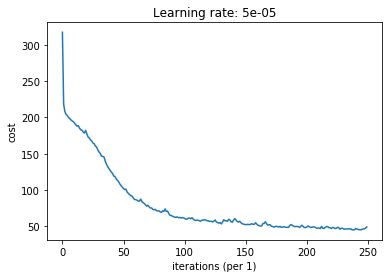

In [16]:
fig = plt.figure()
plt.plot(np.squeeze(np.sqrt(costs)))
plt.ylabel('cost')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("Learning rate: " + str(learning_rate))
fig.savefig('AlexNet_cost.png')
plt.show()

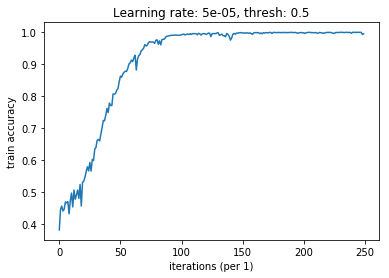

In [17]:
fig = plt.figure()
plt.plot(np.squeeze(train_acc_list))
plt.ylabel('train accuracy')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("Learning rate: " + str(learning_rate) + ", thresh: " + str(thresh))
fig.savefig('AlexNet_train_accuracy.png')
plt.show()

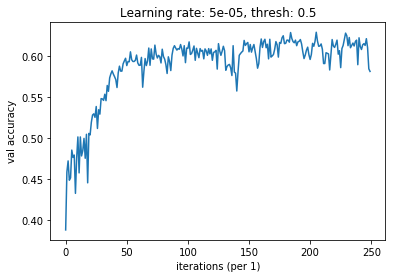

In [18]:
fig = plt.figure()
plt.plot(np.squeeze(val_acc_list))
plt.ylabel('val accuracy')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("Learning rate: " + str(learning_rate) + ", thresh: " + str(thresh))
fig.savefig('AlexNet_val_accuracy.png')
plt.show()

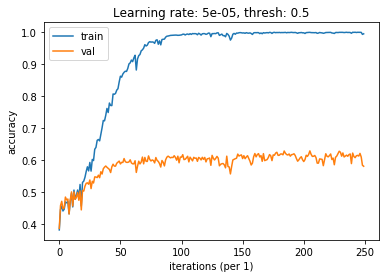

In [30]:
fig = plt.figure()
plt.plot(range(len(val_acc_list)), np.squeeze(train_acc_list), label = "train")
plt.plot(range(len(val_acc_list)), np.squeeze(val_acc_list), label = "val")
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("Learning rate: " + str(learning_rate) + ", thresh: " + str(thresh))
fig.savefig('AlexNet_accuracy.png')
plt.show()

In [79]:
with tf.device('/device:GPU:0'):
    one = train_list[0, :, :, :]
    one_1 = tf.convert_to_tensor(one, np.float32)
    one_1 = tf.reshape(one_1, [1, one_1.shape[0], one_1.shape[1], one_1.shape[2]])
    predictions_one = model.predict(one_1, is_training = False)
    print(predictions_one)
    print(train_label[0, :, :])

tf.Tensor(
[[[ 40.84643   77.51675   76.48987  116.57879  155.52255  101.110504
   117.049835  59.82008   86.51632  152.7905   128.56801  148.63876
   126.666046 136.98816 ]
  [184.7628   146.0073   100.95856  102.18439  144.58061  174.35617
    75.897964  73.137535  46.77815   47.80834   72.82071   79.41589
    40.33221   15.258354]]], shape=(1, 2, 14), dtype=float32)
[[ 50.20740877  83.82652876  85.02721161 130.65316017 172.67706016
  105.43882018 130.65316017  61.01355448  95.83335733 170.27569445
  142.65998874 173.87774302 141.45930588 151.06476874]
 [206.30842279 161.39537968 115.06402995 115.53679882 160.92261081
  191.65258767  83.38851533  84.80682196  53.60407622  53.60407622
   74.87867558  87.64343521  47.45808084  19.56471723]]


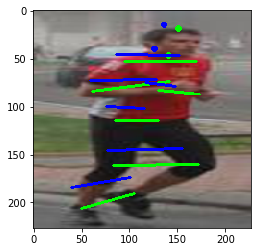

In [80]:
drawLines(train_list[0].copy(),train_label[0].copy(),predictions_one[0])

In [84]:
with tf.device('/device:GPU:0'):
    one = val_list[4, :, :, :]
    one_1 = tf.convert_to_tensor(one, np.float32)
    one_1 = tf.reshape(one_1, [1, one_1.shape[0], one_1.shape[1], one_1.shape[2]])
    predictions_one = model.predict(one_1, is_training = False)
    print(predictions_one)
    print(val_label[0, :, :])

tf.Tensor(
[[[148.94838  136.27847  119.032295  91.905365  79.196526  78.826416
   161.02534  150.85783  127.97826   74.11701   69.732025  80.93536
   104.82136  108.153854]
  [184.86475  136.7061    97.83759   96.73881  135.79735  169.61287
    84.26031   70.87747   43.734726  44.206123  69.39045   86.1251
    34.89083   14.911161]]], shape=(1, 2, 14), dtype=float32)
[[140.53429463 148.19680844 123.11949051  82.71714497  98.04217259
  105.00809423 114.76038454  77.84099982  98.73876475  98.73876475
   75.75122332 133.56837298 109.88423939 123.81608268]
 [213.29073205 169.58454938 125.2713364  124.36079093 165.94236749
  207.52394406 128.91351829  88.84951751  45.44685     46.96442579
   83.99327499  76.1018809   38.46600138  12.667213  ]]


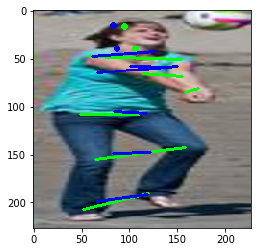

In [83]:
drawLines(val_list[5].copy(),val_label[5].copy(),predictions_one[0])

In [ ]:
print(loss_incr_max)